In [1]:
import pandas as pd
import torch
import torch.nn as nn
# import vaex
import numpy as np
import glob
import dask.dataframe as dd
import json
from sklearn.model_selection import train_test_split
import math
import csv
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import time
import _warnings
from tqdm import tqdm
import swifter
import argparse
import os
from copy import copy, deepcopy
from pathlib import Path
from concurrent import futures
from functools import partial
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

In [ ]:
# from collections import Counter
# from matplotlib import pyplot
# from numpy import where
# from imblearn.over_sampling import SMOTE, ADASYN
# from imblearn.over_sampling import KMeansSMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from collections import Counter
# from sklearn.cluster import MiniBatchKMeans


# epochs_number = 1  # number of epochs for the neural networks
# test_set_size = 0.2  # percentage of the test size comparing to the whole dataset
# oversampling_flag = 1  # set to 1 to over-sample the minority class
# oversampling_percentage = 0.2  # percentage of the minority class after the oversampling comparing to majority class

In [1]:
import sys
import os

%load_ext autoreload
%autoreload 2

sys.path.append('../')
sys.path.insert(0, os.path.dirname(os.getcwd()) + "/../")

print(sys.path)

['/home/hieutt/electricity_theft_detection/../', '/home/hieutt/electricity_theft_detection/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


# PREPROCESSING

In [3]:
# https://github.com/yvesheri4/Identification-of-Electricity-Theft

threshold = 700  # Set the threshold for NaN values

# Load the data
rawData = pd.read_csv('../data/data.csv')

infoData = pd.DataFrame()
infoData['FLAG'] = rawData['FLAG']
infoData['CONS_NO'] = rawData['CONS_NO']
data = rawData.drop(['FLAG', 'CONS_NO'], axis=1)  

# Process Data
# change column name to dates(2014/1/1 to 2014-01-01)
data.columns = pd.to_datetime(data.columns)  #columns reindexing according to dates
data = data.reindex(sorted(data.columns), axis=1)   # sort data accoding to date(as previusoly column are unsorted)

#droping duplicate row (31683 if not using)
dropIndex = data[data.duplicated()].index  # duplicates drop
data = data.drop(dropIndex, axis=0)   
infoData = infoData.drop(dropIndex, axis=0)

# Get index of rows with more than 600 NaNs
overthreshhold_index = data[data.isnull().sum(axis=1) > threshold].index  
data = data.drop(overthreshhold_index)
infoData = infoData.drop(overthreshhold_index, axis=0)

#removing row with all zero(Nan) value
zeroIndex = data[(data.sum(axis=1) == 0)].index  # zero rows drop
data = data.drop(zeroIndex, axis=0) 
infoData = infoData.drop(zeroIndex, axis=0) 

# reindex row name (as some row has been remove till this step due to duplicate or all nan values)
data.reset_index(inplace=True, drop=True)  # index sorting
infoData.reset_index(inplace=True, drop=True)

data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31403,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31404,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [4]:
df_complete = pd.concat([infoData, data], axis=1)

df_complete[df_complete['FLAG'] == 1].shape, df_complete[df_complete['FLAG'] == 0].shape

((2656, 1036), (28750, 1036))

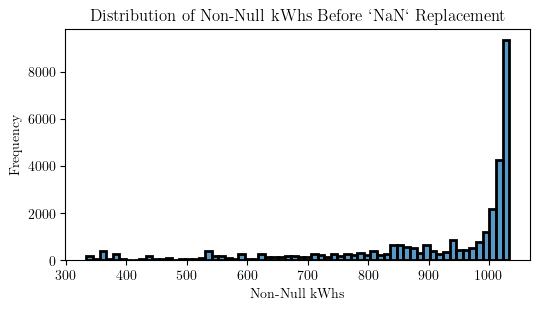

In [5]:
# Find's boolean mask of non-null values, then sums them by row - only checking kWhs
# non_null_counts_by_consumer = rawData.iloc[:, 2:].notnull().sum(axis=1)
non_null_counts_by_consumer = data.notnull().sum(axis=1)

# Print first five values to check
non_null_counts_by_consumer.head()

# Using a distribution plot to visualize non-null counts in data
plt.figure(figsize=(6, 3))
sns.histplot(non_null_counts_by_consumer, kde=False, edgecolor='k', linewidth=2)
plt.xlabel('Non-Null kWhs')
plt.ylabel('Frequency')
plt.title('Distribution of Non-Null kWhs Before `NaN` Replacement')

# Display the plot
plt.show()

In [6]:
max_by_consumer = data.max(axis=1)
average_by_consumer = data.mean(axis=1)
std_by_consumer = data.std(axis=1)

data.max().max(), data.mean().mean(), max_by_consumer.idxmax()

(800003.32, 9.71731469379608, 5468)

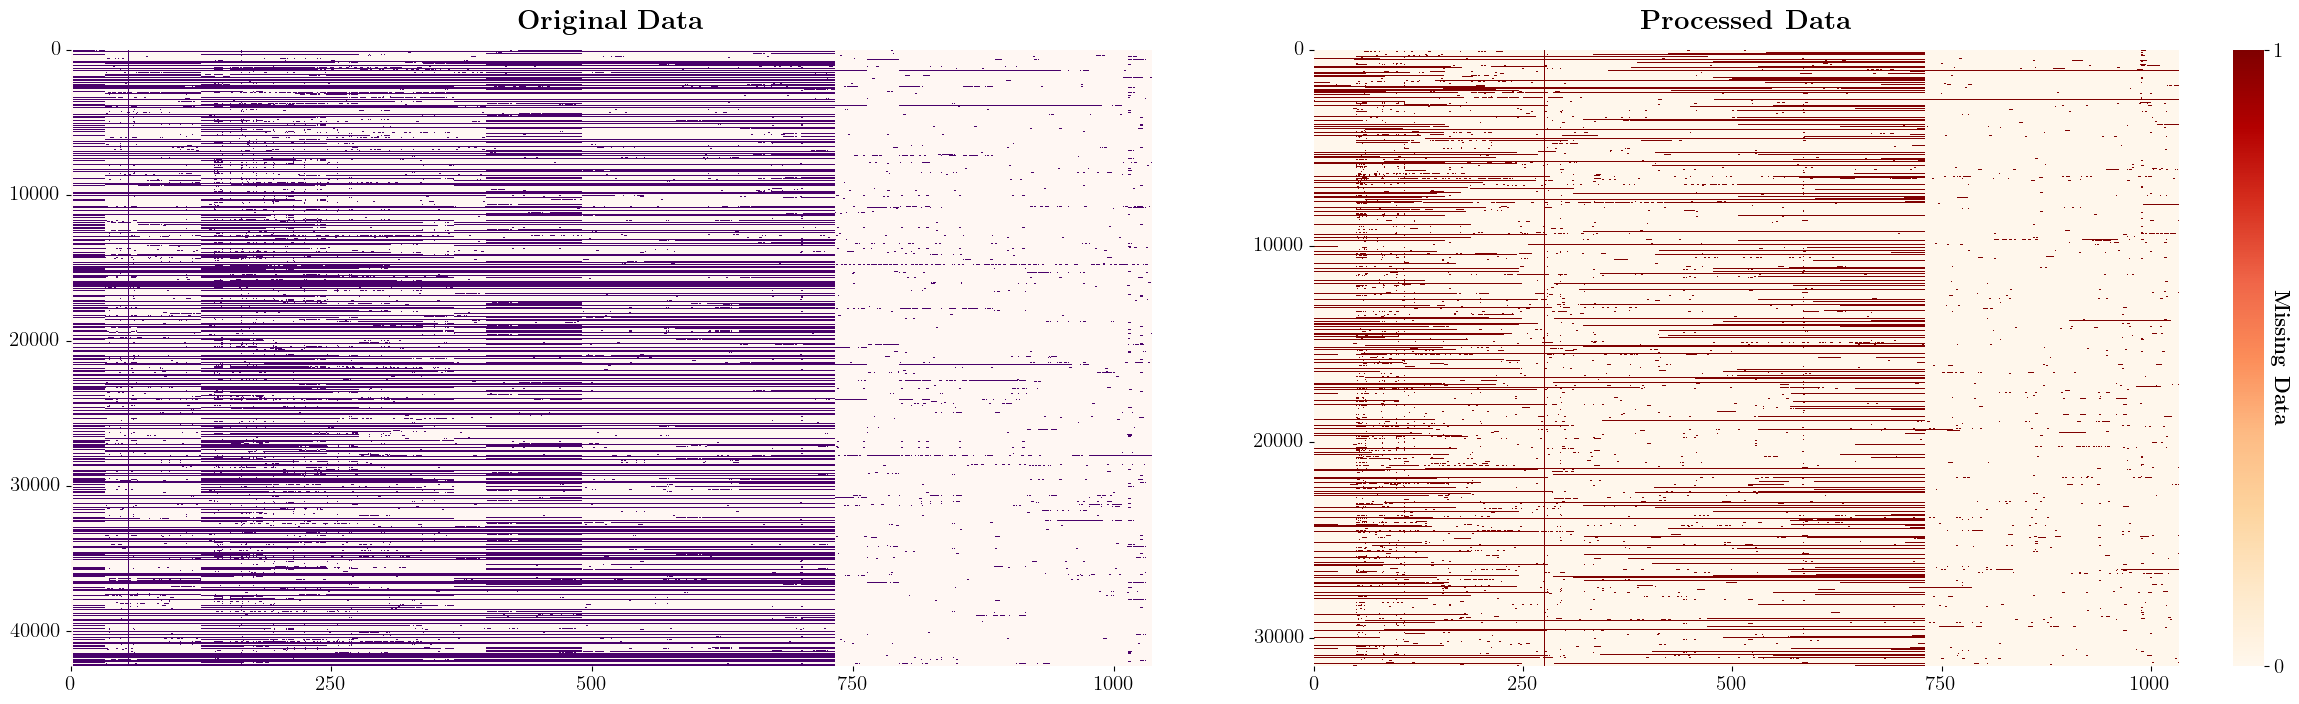

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(30,8))

sns.heatmap(rawData.transpose().isna().transpose(),
            cmap="RdPu", ax=axs[0], cbar=False)
axs[0].set_title(r'\textbf{Original Data}', fontsize=20, y=1.02)
axs[0].set_xticks([0, 250, 500,750,1000])
axs[0].set_xticklabels([0, 250, 500,750,1000], rotation=0, fontsize=15)
axs[0].set_yticks([0,10000, 20000, 30000, 40000])
axs[0].set_yticklabels([0, 10000, 20000, 30000, 40000], fontsize=15)

# cmap="OrRd"
cbar_ax = sns.heatmap(data.transpose().isna().transpose(),
            cmap="OrRd",
            cbar_kws={"ticks":[0,1]}, ax=axs[1]).collections[0].colorbar

# Set the label size of the colorbar
cbar_ax.ax.yaxis.set_tick_params(labelsize=15)
cbar_ax.set_label(r'\textbf{Missing Data}', rotation=-90, size=15)

axs[1].set_title(r'\textbf{Processed Data}', fontsize=20, y=1.02)
axs[1].set_xticks([0, 250, 500,750,1000])
axs[1].set_xticklabels([0, 250, 500,750,1000], rotation=0, fontsize=15)
axs[1].set_yticks([0,10000, 20000,30000])
axs[1].set_yticklabels([0,10000, 20000,30000], fontsize=15)

plt.subplots_adjust(wspace=0.15)
plt.show()

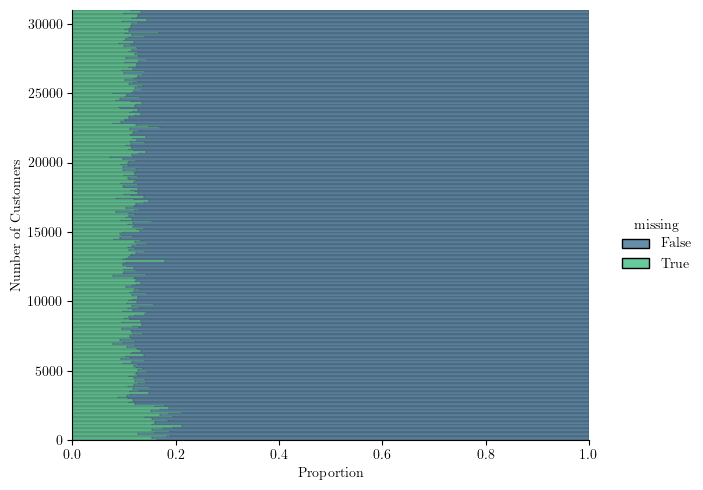

In [8]:
b=sns.displot(
    data=data.transpose().isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25,
    palette="viridis"
)
# b.set_xticklabels(size = 12)
# b.set_yticklabels(size = 12)
plt.xlabel('Proportion')
plt.ylabel('Number of Customers')
plt.ylim([0,31000])
plt.show()
# plt.savefig('missing_P.png')


In [9]:
balancing_data = data.copy(deep=True)
balancing_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31403,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31404,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


# KNN Imputation testing


In [10]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Apply the KNN imputation only to the consumption columns (leave the label column as is)
imputer_result = knn_imputer.fit_transform(balancing_data)
imputer_result

array([[ 4.994,  7.3  ,  6.202, ...,  7.54 ,  9.16 ,  6.74 ],
       [23.924, 17.866, 17.236, ..., 19.26 , 14.46 , 11.72 ],
       [ 2.9  ,  5.64 ,  6.99 , ..., 10.89 ,  9.86 ,  8.72 ],
       ...,
       [ 2.7  ,  0.   ,  0.   , ...,  6.22 ,  6.05 ,  4.77 ],
       [ 0.58 ,  1.16 ,  0.92 , ...,  0.66 ,  0.39 ,  0.65 ],
       [16.89 , 15.15 , 19.28 , ..., 13.16 , 13.33 , 10.39 ]])

### Fill the missing values

In this work, we exploit the interpolation method to recover the missing values according to the following equation,

\begin{equation}
f(x_i)=
\begin{cases}
\frac{x_{i-1}+x_{i+1}}{2} \quad  x_i \in NaN,\;x_{i-1},x_{i+1} \notin NaN \\
0 \quad\quad\quad \;  x_i \in NaN,\;x_{i-1}\;or\; x_{i+1} \in NaN \\
x_i \quad \quad \quad  x_i \notin NaN
\end{cases}
\end{equation}

The interpolate() function uses existing values in the DataFrame to estimate the missing rows.

In [5]:
balancing_data = balancing_data.interpolate(method='linear', limit=2, limit_direction='both', axis=1).fillna(0)
balancing_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31401,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31402,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31403,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31404,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [19]:
df_outliner_processed = pd.DataFrame(imputer_result, columns=data.columns)
df_outliner_processed

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
2,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
3,5.20,2.35,2.56,1.46,2.04,5.38,2.73,0.16,3.28,8.03,...,12.02,13.50,9.45,8.81,10.24,15.89,13.00,14.80,14.91,9.03
4,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.83,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,23.26,24.57,24.25,0.00,23.79,20.93,20.59,25.95,18.52,19.00,...,8.64,8.00,13.02,8.40,10.21,8.61,7.03,8.41,9.84,8.69
15416,36.35,6.72,4.41,1.26,0.00,0.00,0.00,0.00,0.00,0.00,...,23.93,33.49,30.00,29.86,32.41,35.18,38.41,26.18,30.13,33.64
15417,2.03,2.82,1.93,2.13,1.81,2.91,1.73,1.53,1.93,1.32,...,2.29,1.54,2.13,2.05,2.80,2.29,2.22,2.34,2.52,1.84
15418,5.22,5.04,4.92,4.88,13.59,10.73,4.80,6.34,7.07,0.00,...,7.20,9.09,6.53,10.11,9.22,6.78,7.83,14.42,9.58,8.65


In [20]:
last_col_name = df_outliner_processed.columns[-1]

df_outliner_processed['2016-11-01'] = df_outliner_processed[last_col_name]
df_outliner_processed['2016-11-02'] = df_outliner_processed[last_col_name]
df_outliner_processed

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31,2016-11-01,2016-11-02
0,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72,8.72,8.72
1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40,1.40,1.40
2,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91,2.91,2.91
3,5.20,2.35,2.56,1.46,2.04,5.38,2.73,0.16,3.28,8.03,...,9.45,8.81,10.24,15.89,13.00,14.80,14.91,9.03,9.03,9.03
4,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,23.26,24.57,24.25,0.00,23.79,20.93,20.59,25.95,18.52,19.00,...,13.02,8.40,10.21,8.61,7.03,8.41,9.84,8.69,8.69,8.69
15416,36.35,6.72,4.41,1.26,0.00,0.00,0.00,0.00,0.00,0.00,...,30.00,29.86,32.41,35.18,38.41,26.18,30.13,33.64,33.64,33.64
15417,2.03,2.82,1.93,2.13,1.81,2.91,1.73,1.53,1.93,1.32,...,2.13,2.05,2.80,2.29,2.22,2.34,2.52,1.84,1.84,1.84
15418,5.22,5.04,4.92,4.88,13.59,10.73,4.80,6.34,7.07,0.00,...,6.53,10.11,9.22,6.78,7.83,14.42,9.58,8.65,8.65,8.65


In [8]:
df_outliner_processed['label'] = infoData['FLAG']
df_outliner_processed

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,label
0,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72,1
1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40,1
2,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91,1
3,5.20,2.35,2.56,1.46,2.04,5.38,2.73,0.16,3.28,8.03,...,13.50,9.45,8.81,10.24,15.89,13.00,14.80,14.91,9.03,1
4,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.83,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,23.26,24.57,24.25,0.00,23.79,20.93,20.59,25.95,18.52,19.00,...,8.00,13.02,8.40,10.21,8.61,7.03,8.41,9.84,8.69,0
15416,36.35,6.72,4.41,1.26,0.00,0.00,0.00,0.00,0.00,0.00,...,33.49,30.00,29.86,32.41,35.18,38.41,26.18,30.13,33.64,0
15417,2.03,2.82,1.93,2.13,1.81,2.91,1.73,1.53,1.93,1.32,...,1.54,2.13,2.05,2.80,2.29,2.22,2.34,2.52,1.84,0
15418,5.22,5.04,4.92,4.88,13.59,10.73,4.80,6.34,7.07,0.00,...,9.09,6.53,10.11,9.22,6.78,7.83,14.42,9.58,8.65,0


In [44]:
import time

# Attempting numpy array-based solution
kWhs = data.values.copy()

# Does it have the right shape
rows, cols = kWhs.shape

# Record time at beginning of loop
t_0 = time.time()

# For every consumer
for i in range(0, rows):
  # Print a dot as an update after every 400 consumers
  if (i % 400  == 0):
    print("*", end="")

  # And for every value of that consumer
  for j in range(1, cols - 1):
    # If the current value is undefined
    if (np.isnan(kWhs[i, j])):
      if (~np.isnan(kWhs[i, j - 1]) and ~np.isnan(kWhs[i, j + 1])):
        kWhs[i, j] = np.mean([kWhs[i, j - 1], kWhs[i, j + 1]])
      elif(np.isnan(kWhs[i, j - 1]) or np.isnan(kWhs[i, j + 1])):
        kWhs[i, j] = 0.0

# Record time at end of loop
t_f = time.time()
print('\n', (t_f - t_0)/60)

****************************************************************************
 0.8445790489514668


In [16]:
outliner_processing = balancing_data.copy(deep=True)

# For testing purpose

In [2]:
import os
import numpy as np
import pandas as pd

# Directory containing the .npz files
directory = ['../data/ksm_transformer_best_result/train', '../data/ksm_transformer_best_result/val']

# List to hold the data


# Loop through all files in the directory
for dir in directory:
    data_list = []
    label_list = []
    for filename in os.listdir(dir):
        if filename.endswith('.npz'):
            # Load the .npz file
            file_path = os.path.join(dir, filename)
            with np.load(file_path) as data:
                # Assuming the .npz file contains arrays, extract them
                consump = data['X'] 
                label = data['y']
                
                data_list.append(consump.flatten().tolist())
                label_list.append(label.flatten().tolist()[0])
    if 'train' in dir:
        train_data = pd.DataFrame(data_list)
        train_data['label'] = label_list
    else:
        val_data = pd.DataFrame(data_list)
        val_data['label'] = label_list

train_data

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,10.420000,7.640000,0.000000,10.700000,10.290000,9.740000,9.440000,7.600000,8.890000,6.550000,...,7.780000,9.270000,8.360000,8.050000,5.300000,6.710000,5.210000,0.0,0.0,0
1,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.270000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.290000,0.0,0.0,0
2,7.010000,10.710000,9.930000,3.810000,6.290000,11.490000,12.900000,11.990000,11.860000,13.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
3,8.190000,8.760000,8.400000,7.660000,8.590000,9.020000,7.430000,8.710000,7.610000,8.310000,...,0.460000,0.200000,0.410000,0.170000,0.300000,0.150000,0.870000,0.0,0.0,0
4,0.000000,0.000000,0.000000,0.620000,0.640000,0.000000,0.620000,0.620000,0.000000,0.620000,...,11.330000,12.670000,10.770000,11.830000,10.410000,13.140000,15.940000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46637,2.860000,3.860000,4.770000,6.051058,4.480000,3.160000,4.470000,6.051058,5.550000,4.160000,...,1.240000,1.940000,1.910000,1.480000,1.290000,3.100000,2.790000,0.0,0.0,0
46638,654.631172,514.214025,1088.133320,752.877057,721.278273,597.648886,1269.155858,942.391366,480.578557,1271.997487,...,2833.660625,2821.080811,2387.381191,1442.528456,2230.720873,2619.803794,2559.001362,0.0,0.0,1
46639,138.524410,139.787638,141.337886,142.030297,138.576210,137.897428,129.316589,129.544481,128.686132,127.315768,...,223.851510,228.851510,219.263270,227.773288,215.670505,207.447760,213.578115,0.0,0.0,1
46640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.490000,1.700000,1.140000,1.140000,1.110000,1.420000,1.160000,0.0,0.0,0


In [3]:
import os
import numpy as np
import pandas as pd

# Directory containing the .npz files
directory = ['../data/non_ksm_transformer/train', '../data/non_ksm_transformer/val']

# List to hold the data


# Loop through all files in the directory
for dir in directory:
    data_list = []
    label_list = []
    for filename in os.listdir(dir):
        if filename.endswith('.npz'):
            # Load the .npz file
            file_path = os.path.join(dir, filename)
            with np.load(file_path) as data:
                # Assuming the .npz file contains arrays, extract them
                consump = data['X'] 
                label = data['y']
                
                data_list.append(consump.flatten().tolist())
                label_list.append(label.flatten().tolist()[0])
    if 'train' in dir:
        train_data = pd.DataFrame(data_list)
        train_data['label'] = label_list
    else:
        val_data = pd.DataFrame(data_list)
        val_data['label'] = label_list

train_data

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,4.96,4.40,5.68,7.87,5.55,6.62,7.85,0.0,0.0,0
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,1.74,1.91,1.81,2.16,1.89,1.98,1.89,0.0,0.0,0
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,2.37,3.01,2.90,2.88,3.97,2.72,3.25,0.0,0.0,0
3,9.34000,15.16000,14.40000,15.24000,14.63000,13.62000,13.01,15.39000,11.35000,8.08,...,11.86,13.60,17.86,13.38,14.01,11.20,12.91,0.0,0.0,1
4,0.77000,0.77000,0.68000,0.01000,0.10000,0.03000,0.09,0.04000,0.25000,0.84,...,1.27,1.54,1.70,0.98,0.75,1.33,0.56,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25342,0.25000,0.65000,1.53000,5.73000,5.26000,1.60000,0.99,1.18000,0.96000,1.10,...,11.66,11.54,10.69,11.24,11.08,9.14,10.12,0.0,0.0,0
25343,16.37371,16.37371,16.37371,16.37371,16.37371,16.37371,13.22,16.37371,16.37371,16.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1
25344,3.91000,5.59000,4.50000,5.31000,2.91000,3.98000,3.33,4.22000,6.38000,6.02,...,4.76,3.13,5.95,6.01,3.03,4.49,2.30,0.0,0.0,0
25345,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0


In [19]:
threshold = 500 # if values are greater than 500, then it is an outlier

reducing_df = val_data.copy(deep=True)

df_outliner = reducing_df[(reducing_df > threshold).any(axis=1)]

df_outliner 

bool_df = df_outliner > threshold

outlier_threshold = 75 # if a sample has more than 50 columns with values greater than threshold, then we should keep it

count_per_column = bool_df.sum(axis=1)

drop_index = count_per_column[count_per_column < outlier_threshold].index
consider_index = count_per_column[count_per_column >= outlier_threshold].index

print(f"Shape: {consider_index.shape[0]} and total samples that have value more than threshold: {df_outliner.shape[0]}")

drop_if_overthreshold = []
for i in consider_index:
    if reducing_df.iloc[i].max() > 1000: # if the max value of a sample is greater than 50000, then we should drop it
        # print(i)   
        drop_if_overthreshold.append(i)

drop_index = pd.Index(drop_index.tolist() + drop_if_overthreshold)

filtered_data = reducing_df.loc[consider_index]
print("Number of attack samples: ", filtered_data[filtered_data['label'] == 1].shape[0])
drop_index, consider_index

Shape: 7 and total samples that have value more than threshold: 18
Number of attack samples:  5


(Index([2127, 2254, 3213, 4068, 4351, 4835, 5369, 5641, 5666, 6086, 6170, 5459], dtype='int64'),
 Index([1031, 1225, 3186, 4226, 4339, 5459, 5546], dtype='int64'))

In [20]:
train_data_reduced = train_data.drop(drop_index, axis=0) 
train_data_reduced.reset_index(inplace=True, drop=True)
train_data_reduced

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,4.96,4.40,5.68,7.87,5.55,6.62,7.85,0.0,0.0,0
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,1.74,1.91,1.81,2.16,1.89,1.98,1.89,0.0,0.0,0
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,2.37,3.01,2.90,2.88,3.97,2.72,3.25,0.0,0.0,0
3,9.34000,15.16000,14.40000,15.24000,14.63000,13.62000,13.01,15.39000,11.35000,8.08,...,11.86,13.60,17.86,13.38,14.01,11.20,12.91,0.0,0.0,1
4,0.77000,0.77000,0.68000,0.01000,0.10000,0.03000,0.09,0.04000,0.25000,0.84,...,1.27,1.54,1.70,0.98,0.75,1.33,0.56,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25330,0.25000,0.65000,1.53000,5.73000,5.26000,1.60000,0.99,1.18000,0.96000,1.10,...,11.66,11.54,10.69,11.24,11.08,9.14,10.12,0.0,0.0,0
25331,16.37371,16.37371,16.37371,16.37371,16.37371,16.37371,13.22,16.37371,16.37371,16.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1
25332,3.91000,5.59000,4.50000,5.31000,2.91000,3.98000,3.33,4.22000,6.38000,6.02,...,4.76,3.13,5.95,6.01,3.03,4.49,2.30,0.0,0.0,0
25333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0


In [21]:
val_data_reduced = val_data.drop(drop_index, axis=0) 
val_data_reduced.reset_index(inplace=True, drop=True)
val_data_reduced

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,132.57,143.01,131.51,131.15,114.89,114.94,114.00,0.0,0.0,1
1,0.03,0.01,0.01,0.01,0.00,0.01,0.00,0.01,0.01,0.01,...,5.12,2.93,3.47,2.69,0.08,0.08,3.84,0.0,0.0,0
2,16.97,15.08,15.86,13.36,15.19,13.43,12.50,14.05,15.00,12.30,...,17.91,19.19,18.06,21.84,20.35,17.41,16.76,0.0,0.0,0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.95,2.30,2.48,1.86,1.77,2.25,1.80,0.0,0.0,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.64,2.07,2.70,2.68,2.15,1.62,1.77,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6319,0.00,4.15,0.00,5.73,6.80,8.27,6.11,5.69,5.61,6.05,...,8.77,10.68,8.42,9.18,8.39,10.20,8.43,0.0,0.0,0
6320,5.18,6.86,0.00,0.00,0.00,7.54,5.07,0.00,7.55,0.00,...,15.15,11.42,12.64,11.80,13.09,8.22,0.00,0.0,0.0,0
6321,9.79,9.63,7.85,8.49,8.75,8.23,8.80,5.91,10.14,8.60,...,6.64,7.10,8.54,7.66,7.27,7.42,6.36,0.0,0.0,0
6322,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.27,0.13,0.26,0.21,0.17,0.26,0.22,0.0,0.0,0


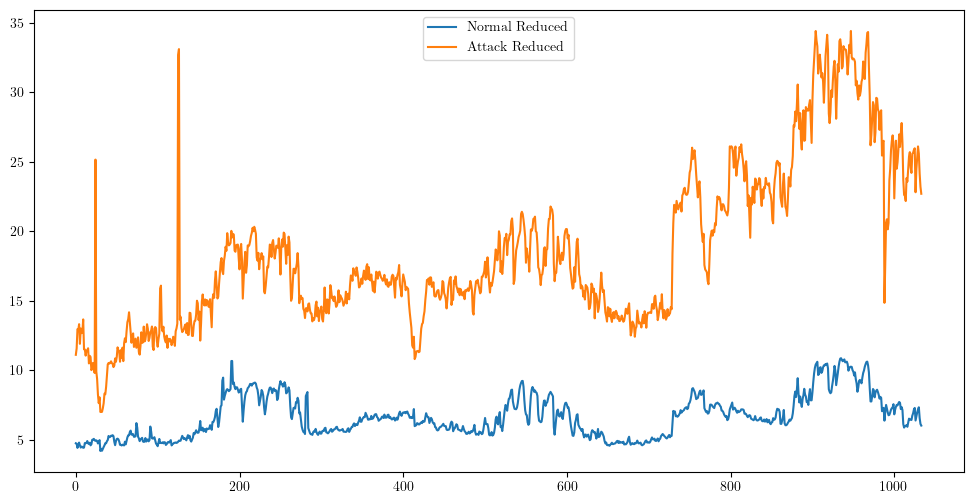

In [22]:
plt.figure(figsize=(12, 6))

# visualize_df = train_data.copy(deep=True) 

# attack_df = visualize_df[visualize_df['label'] == 1]
# normal_df = visualize_df[visualize_df['label'] == 0]

# # Calculate the average (mean) value per column
# average_values_normal = normal_df.iloc[:, :-3].mean()
# average_values_attack = attack_df.iloc[:, :-3].mean()

# # Plot the Series
# average_values_normal.plot(label='Normal')
# average_values_attack.plot(label='Attack')

# For reduced

visualize_df = train_data_reduced.copy(deep=True)

attack_df = visualize_df[visualize_df['label'] == 1]
normal_df = visualize_df[visualize_df['label'] == 0]

# Calculate the average (mean) value per column
average_values_normal = normal_df.iloc[:, :-3].mean()
average_values_attack = attack_df.iloc[:, :-3].mean()

# Plot the Series

average_values_normal.plot(label='Normal Reduced')
average_values_attack.plot(label='Attack Reduced')

plt.legend()    

# Show the plot
plt.show()

In [ ]:

generated_data = np.load('../data/GAN_data.npz', allow_pickle=True)

consump = generated_data['data']
label = generated_data['label']

GAN_gen = pd.DataFrame(consump)

# Map each row to a flattened list
GAN_gen = GAN_gen.applymap(lambda x: x.flatten().tolist())

# Create a new DataFrame from the list of numbers in column 0
expanded_cols = pd.DataFrame(GAN_gen[0].tolist())

# Concatenate the new DataFrame with the original DataFrame, excluding the original column 0
GAN_gen = pd.concat([expanded_cols, pd.Series(label.flatten(), name='label')], axis=1)

# Display the resulting DataFrame
(GAN_gen)

In [ ]:
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN

# Assuming train_data is already loaded and contains features and a target column 'label'
# Separate features and target
X = train_data_reduced.iloc[:, :-3]
y = train_data_reduced['label']

X_val = val_data_reduced.iloc[:, :-3]
y_val = val_data_reduced['label']

# Apply Borderline-SMOTE
smote = BorderlineSMOTE(random_state=42)
smote_enn = SMOTEENN(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X, y)

X_resampled_val, y_resampled_val = smote.fit_resample(X_val, y_val)
X_resampled_enn_val, y_resampled_enn_val = smote_enn.fit_resample(X_val, y_val)


# Create synthetic_data using pd.concat
synthetic_data = pd.concat([pd.DataFrame(X_resampled[len(X):], columns=X.columns), 
                            pd.Series(y_resampled[len(X):], name='label')], axis=1)

# Create synthetic_data_enn using pd.concat
synthetic_data_enn = pd.concat([pd.DataFrame(X_resampled_enn[len(X):], columns=X.columns), 
                                pd.Series(y_resampled_enn[len(X):], name='label')], axis=1)

# Create synthetic_data_val using pd.concat
synthetic_data_val = pd.concat([pd.DataFrame(X_resampled_val[len(X_val):], columns=X_val.columns), 
                                pd.Series(y_resampled_val[len(X_val):], name='label')], axis=1)

# Create synthetic_data_enn_val using pd.concat
synthetic_data_enn_val = pd.concat([pd.DataFrame(X_resampled_enn_val[len(X_val):], columns=X_val.columns), 
                                    pd.Series(y_resampled_enn_val[len(X_val):], name='label')], axis=1)


# Calculate the average (mean) value per column
average_values_normal = normal_df.iloc[:, :-3].mean()
average_values_attack = attack_df.iloc[:, :-3].mean()
avarage_values_generated = synthetic_data.iloc[:, :-1].mean()
avarage_values_generated_enn = synthetic_data_enn.iloc[:, :-1].mean()

average_values_normal_val = normal_df.iloc[:, :-3].mean()
average_values_attack_val = attack_df.iloc[:, :-3].mean()
avarage_values_generated_val = synthetic_data_val.iloc[:, :-1].mean()
avarage_values_generated_enn_val = synthetic_data_enn_val.iloc[:, :-1].mean()

In [23]:
max_by_consumer = outliner_processing.max(axis=1)
average_by_consumer = outliner_processing.mean(axis=1)
std_by_consumer = outliner_processing.std(axis=1)
min_by_consumer = outliner_processing.min(axis=1)

max_by_consumer.mean(), average_by_consumer.mean(), std_by_consumer.mean(), min_by_consumer.mean()  

(34.7369918823884, 7.957107803473322, 5.682359762587021, 0.004576537959211012)

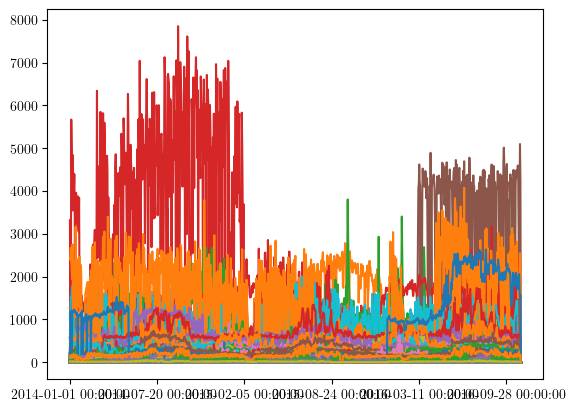

In [24]:
list_check = balancing_data[(balancing_data >= 100000).any(axis=1)].max(axis=1).index.tolist()

for i in outliner_processing.index:
    # if balancing_data.iloc[i].mean() < 2:
    #     print(i)
    if i in [2064, 2384]:
        continue
    outliner_processing.iloc[i].plot()
plt.show()

In [23]:
for i in range(df_outliers_handled.shape[0]):
    mean = df_outliers_handled.loc[i].mean()
    sd = df_outliers_handled.loc[i].std()
    Q1 = df_outliers_handled.loc[i].quantile(0.25)
    Q3 = df_outliers_handled.loc[i].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_limit = Q3 + 3 * IQR
    lower_limit = Q1 - 3 * IQR
    
    # upper_limit = mean + 2 * sd
    # lower_limit = mean - 2 * sd
    
    # print(f"Row: {i}, Mean: {mean}, SD: {sd}, Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, \nUpper Threshold: {upper_threshold}, Lower Threshold: {lower_threshold}, \nUpper Limit: {upper_limit}, Lower Limit: {lower_limit}")
    
    # Capping the data at the upper and lower sigma limits.
    df_outliers_handled.loc[i] = np.where(df_outliers_handled.loc[i] > upper_limit, upper_limit, 
                                          np.where(df_outliers_handled.loc[i] < lower_limit, lower_limit, df_outliers_handled.loc[i]))


### Handling the outliers

We restore the value by following equation according to "Three-sigma rule of dumb"

\begin{equation}
f(x_i)=
\begin{cases}
avg(\mathbf{x})+3\cdot std(\mathbf{x}) \quad  if \; x_i > avg(\mathbf{x})+3\cdot std(\mathbf{x})\\
x_i \quad \quad \quad otherwise
\end{cases}
\end{equation}

# After preprocessing
This file `processed_data_H.csv` is  a CSV file that contains the processed data. 

In [4]:
cleaned_df = pd.read_csv('../data/processed_data_H.csv')
cleaned_df.drop(['Unnamed: 0'], axis=1, inplace=True)
cleaned_df

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


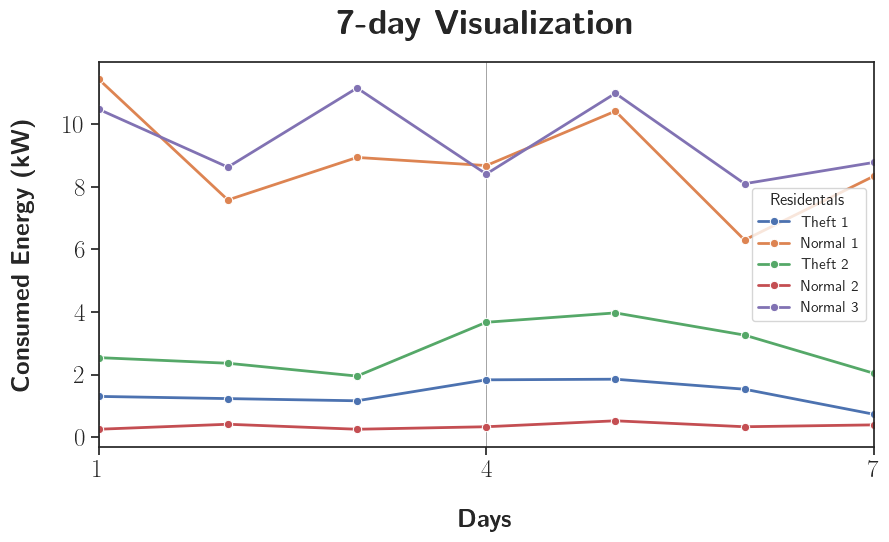

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

# rows = [cleaned_df.iloc[0, 0:28] for _ in range(5)]
# Assuming df is your DataFrame and you want to visualize the first row
rows = cleaned_df.iloc[[7, 2590, 10, 3617, 26723], 301:308]
# rows = [cleaned_df.iloc[2609, 0+28*i:28*i+28] for i in range(1, 10)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 8)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["Theft 1" for _ in range(7)], ["Normal 1" for _ in range(7)], ["Theft 2" for _ in range(7)], ["Normal 2" for _ in range(7)], ["Normal 3" for _ in range(7)]]).flatten().tolist()
})


# Set a theme
# sns.axes_style()
sns.set_theme(style="ticks")

# Create a lineplot
plt.figure(figsize=(10, 5))

sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o')

# Define the markers
# markers = ['o', 'v', '^', '<', '>']

# Get the unique residentals
# residentals = data['Residentals'].unique()

# Create a lineplot for each residental
# for i, residental in enumerate(residentals):
#     df_residental = data[data['Residentals'] == residental]
#     sns.lineplot(x='Day', y='Value', data=df_residental, marker=markers[i % len(markers)], linewidth=2)

# Add title and labels
plt.title(r'\textbf{7-day Visualization}', fontsize=25, pad=20)
plt.xlabel(r'\textbf{Days}', fontsize=18, labelpad=20)
plt.ylabel(r'\textbf{Consumed Energy (kW)}', fontsize=18, labelpad=20)

# Set xticks to only show the first and last day
plt.xticks([0, 1, 4, 7], fontsize=18)
plt.yticks(fontsize=18)

# Get the current axes, enabling you to manipulate its properties
ax = plt.gca()

# Display only vertical gridlines
ax.grid(True, which='both', axis='x', color='gray', linewidth=0.5)

# Set x-axis limits
plt.xlim(1, 7)

# Show the plot
plt.show()

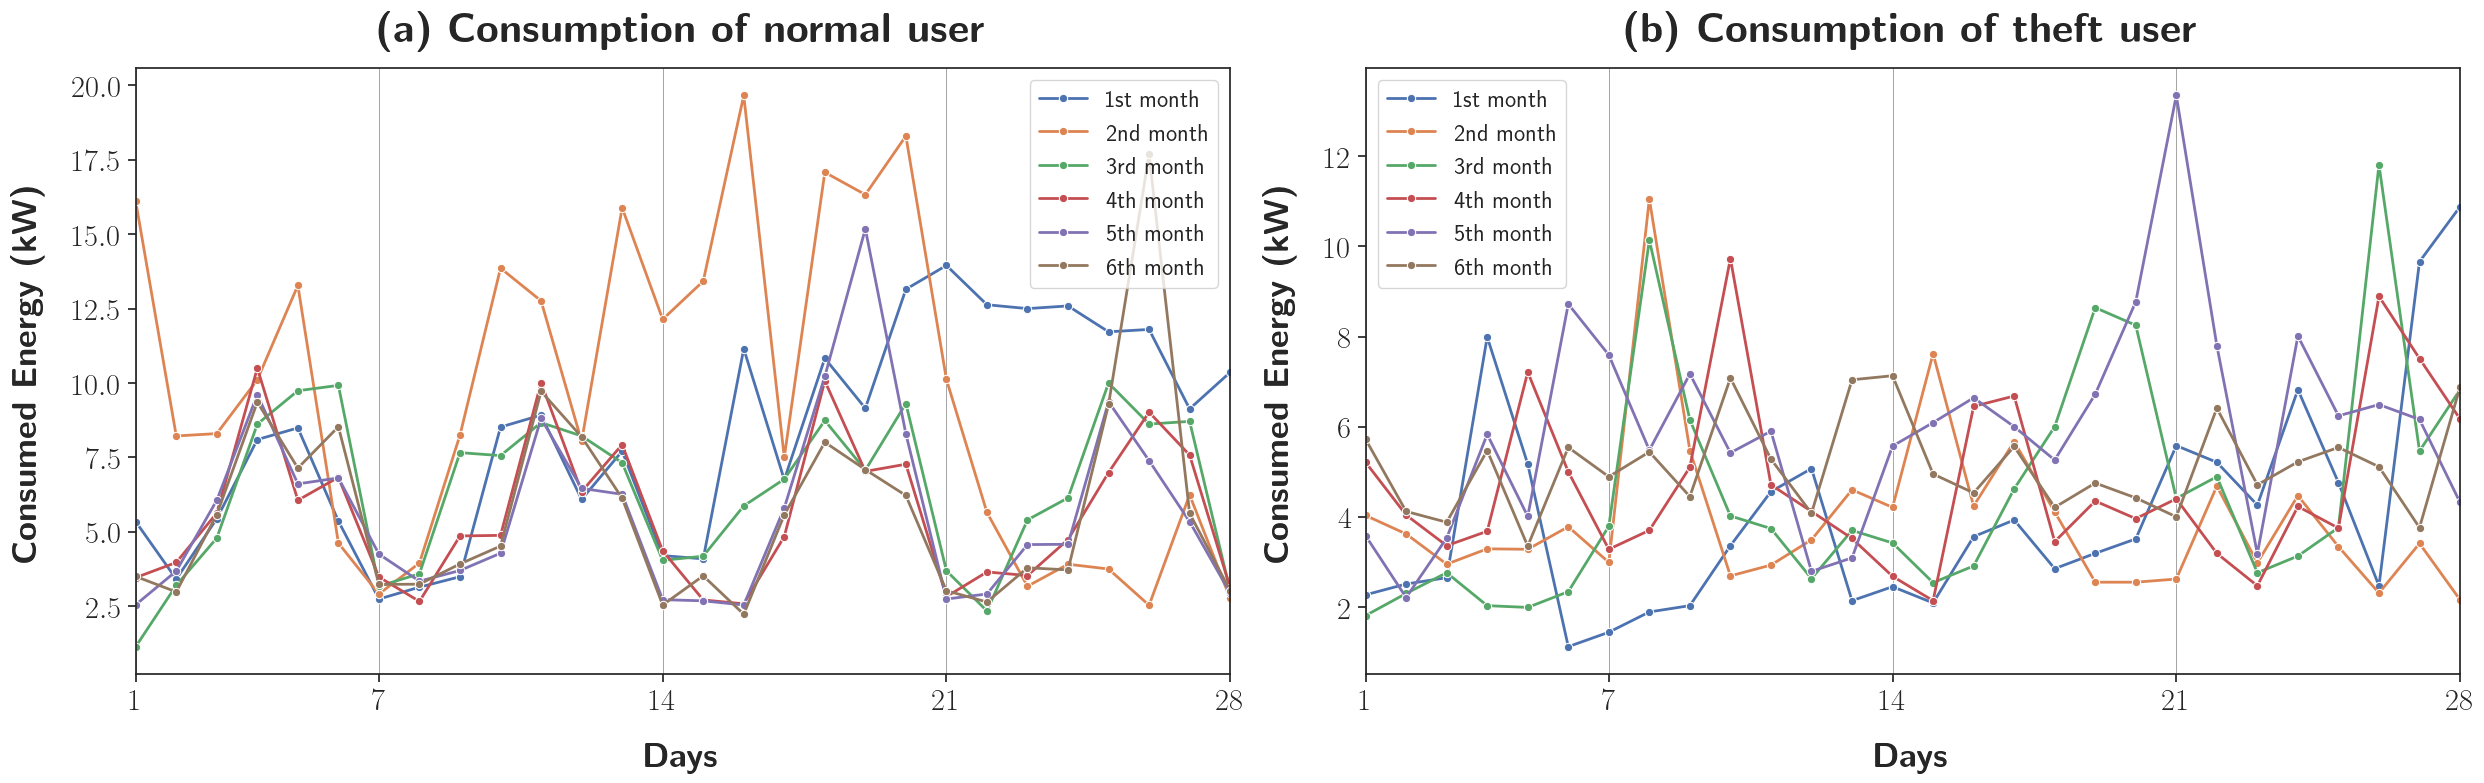

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

sns.set_theme(style="ticks")

# Assuming df is your DataFrame and you want to visualize the first row
rows = [cleaned_df.iloc[12290, 0+28*i:28*i+28] for i in range(0, 6)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["1st month" for _ in range(28)], ["2nd month" for _ in range(28)], ["3rd month" for _ in range(28)], ["4th month" for _ in range(28)], ["5th month" for _ in range(28)], ["6th month" for _ in range(28)]]).flatten().tolist()
})

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Create the first lineplot
sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o', ax=axs[0])
axs[0].set_title(r'\textbf{(a) Consumption of normal user}', fontsize=30, pad=20)
axs[0].set_xlabel(r'\textbf{Days}', fontsize=25, labelpad=20)
axs[0].set_ylabel(r'\textbf{Consumed Energy (kW)}', fontsize=25, labelpad=20)
axs[0].set_xticks([0, 1, 7, 14, 21, 28])
axs[0].tick_params(axis='both', which='major', labelsize=22) 
axs[0].grid(True, which='both', axis='x', color='gray', linewidth=0.5)
axs[0].set_xlim(1, 28)
axs[0].legend(fontsize='x-large')  # Change font size of legend

# Assuming df is your DataFrame and you want to visualize the first row
rows = [cleaned_df.iloc[43, 0+28*i:28*i+28] for i in range(0, 6)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["1st month" for _ in range(28)], ["2nd month" for _ in range(28)], ["3rd month" for _ in range(28)], ["4th month" for _ in range(28)], ["5th month" for _ in range(28)], ["6th month" for _ in range(28)]]).flatten().tolist()
})

# Create the second lineplot
# (replace 'data2' with your second DataFrame)
sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o', ax=axs[1])
axs[1].set_title(r'\textbf{(b) Consumption of theft user}', fontsize=30, pad=20)
axs[1].set_xlabel(r'\textbf{Days}', fontsize=25, labelpad=20)
axs[1].set_ylabel(r'\textbf{Consumed Energy (kW)}', fontsize=25, labelpad=20)
axs[1].set_xticks([0, 1, 7, 14, 21, 28])
axs[1].tick_params(axis='both', which='major', labelsize=22) 
axs[1].grid(True, which='both', axis='x', color='gray', linewidth=0.5)
axs[1].set_xlim(1, 28)
axs[1].legend(fontsize='x-large')  # Change font size of legend

# Show the plot
plt.tight_layout()
plt.show()

The `new_info2.csv` is csv file that contains flag and cons_no after preprocessing

In [5]:
flag = pd.read_csv('../data/new_info2.csv')
flag.drop(['Unnamed: 0'], axis=1, inplace=True)
flag

,FLAG,CONS_NO
0,1,0387DD8A07E07FDA6271170F86AD9151
1,1,B32AC8CC6D5D805AC053557AB05F5343
2,1,EDFC78B07BA2908B3395C4EB2304665E
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83
4,1,768309B0EB11FD436CEE5ABFB84F4C0C
...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107
31679,0,F1472871E1AFF49D4289564B6377D76C
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7
31681,0,A9A0FE83467A680FBFB0DBFC910DF227


In [6]:
df_combined = pd.concat([flag, cleaned_df], axis=1)
df_combined

,FLAG,CONS_NO,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,1,0387DD8A07E07FDA6271170F86AD9151,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,1,B32AC8CC6D5D805AC053557AB05F5343,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,1,EDFC78B07BA2908B3395C4EB2304665E,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,1,768309B0EB11FD436CEE5ABFB84F4C0C,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0,F1472871E1AFF49D4289564B6377D76C,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0,A9A0FE83467A680FBFB0DBFC910DF227,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [7]:
sampling_df = df_combined.copy(deep=True)

In [8]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.cluster import MiniBatchKMeans

def undersampling(X, y, ratio=1.0, choice=1):
    # Count of number of samples in each class
    class_counts = Counter(y)

    # Determining the class with fewer samples
    minority_class = min(class_counts, key=class_counts.get)
    majority_class = max(class_counts, key=class_counts.get)

    # Creating SMOTE and Undersampler instances with the specified ratio
    undersampler = RandomUnderSampler(random_state=42)
    
    if choice == 0:
        print("Using SMOTE")
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    elif choice == 1:
        print("Using ADASYN")
        adasyn = ADASYN(random_state=42)
        X_resampled, y_resampled = adasyn.fit_resample(X, y)
    elif choice == 2:
        print("Using BorderlineSMOTE")
        borderline_smote = BorderlineSMOTE(random_state=42)
        X_resampled, y_resampled = borderline_smote.fit_resample(X, y)
    else: 
        print("Using KMeansSMOTE")
        kmean_sm = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42)
        X_resampled, y_resampled = kmean_sm.fit_resample(X, y)
        
    print("Resampled class counts:", Counter(y_resampled))
    # Applying undersampling to reduce the number of samples in the majority class
    # X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)

    # Counting the number of samples in each class in the final resampled dataset
    final_class_counts = Counter(y_resampled)

    return X_resampled, y_resampled, final_class_counts

desired_ratio = 1.0
# SEPARATING DEPENDENT AND INDEPENDENT VARIABLES
x = sampling_df.iloc[:, 2:].values
y = sampling_df.iloc[:, 0].values
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

x_resampled_smote, y_resampled_smote, final_class_counts = undersampling(x, y, ratio=desired_ratio, choice=0)
x_resampled_adasyn, y_resampled_adasyn, final_class_counts = undersampling(x, y, ratio=desired_ratio, choice=1)
x_resampled_borderline, y_resampled_borderline, final_class_counts = undersampling(x, y, ratio=desired_ratio, choice=2)
x_resampled_ksm, y_resampled_ksm, final_class_counts = undersampling(x, y, ratio=desired_ratio, choice=3)

# The final_class_counts will now contain equal numbers of samples for both classes
print("Final class counts:", final_class_counts)

Shape of x: (31683, 1034)
Shape of y: (31683,)
Using SMOTE
Resampled class counts: Counter({1: 29151, 0: 29151})
Using ADASYN
Resampled class counts: Counter({0: 29151, 1: 29029})
Using BorderlineSMOTE
Resampled class counts: Counter({1: 29151, 0: 29151})
Using KMeansSMOTE
Resampled class counts: Counter({1: 29151, 0: 29151})
Final class counts: Counter({1: 29151, 0: 29151})


In [90]:
x.shape, x_resampled_ksm.shape

((31683, 1034), (58302, 1034))

In [9]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

def mmd_rbf(X, Y, kernel=rbf_kernel, gamma=4.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = kernel(X, X, gamma)
    YY = kernel(Y, Y, gamma)
    XY = kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

# mmd_value = compute_mmd(x, x_resampled_ksm)
# print(f"MMD between original and resampled minority samples: {mmd_value}")

mmd_value2 = mmd_rbf(x, x_resampled_ksm)
print(f"KSM: {mmd_value2}")
mmd_value2 = mmd_rbf(x, x_resampled_borderline)
print(f"Borderline: {mmd_value2}")
mmd_value2 = mmd_rbf(x, x_resampled_smote)
print(f"SMOTE: {mmd_value2}")
mmd_value2 = mmd_rbf(x, x_resampled_adasyn)
print(f"ADASYN: {mmd_value2}")

KSM: 0.0007842216912890857
Borderline: 0.0007491490821000188
SMOTE: 0.0006169797918730612
ADASYN: 0.0007300132962907062


In [10]:
mmd_value2 = mmd_rbf(x, x)
print(f"ADASYN: {mmd_value2}")

ADASYN: 0.0


In [42]:
import os
import numpy as np
import pandas as pd

# Directory containing the .npz files
directory = ['../data/ksm_transformer_best_result/train', '../data/ksm_transformer_best_result/val']

# List to hold the data


# Loop through all files in the directory
for dir in directory:
    data_list = []
    label_list = []
    for filename in os.listdir(dir):
        if filename.endswith('.npz'):
            # Load the .npz file
            file_path = os.path.join(dir, filename)
            with np.load(file_path) as data:
                # Assuming the .npz file contains arrays, extract them
                consump = data['X'] 
                label = data['y']
                
                data_list.append(consump.flatten().tolist())
                label_list.append(label.flatten().tolist()[0])
    if 'train' in dir:
        train_data = pd.DataFrame(data_list)
        train_data['label'] = label_list
    else:
        val_data = pd.DataFrame(data_list)
        val_data['label'] = label_list

train_data

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,10.420000,7.640000,0.000000,10.700000,10.290000,9.740000,9.440000,7.600000,8.890000,6.550000,...,7.780000,9.270000,8.360000,8.050000,5.300000,6.710000,5.210000,0.0,0.0,0
1,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.270000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.290000,0.0,0.0,0
2,7.010000,10.710000,9.930000,3.810000,6.290000,11.490000,12.900000,11.990000,11.860000,13.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
3,8.190000,8.760000,8.400000,7.660000,8.590000,9.020000,7.430000,8.710000,7.610000,8.310000,...,0.460000,0.200000,0.410000,0.170000,0.300000,0.150000,0.870000,0.0,0.0,0
4,0.000000,0.000000,0.000000,0.620000,0.640000,0.000000,0.620000,0.620000,0.000000,0.620000,...,11.330000,12.670000,10.770000,11.830000,10.410000,13.140000,15.940000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46637,2.860000,3.860000,4.770000,6.051058,4.480000,3.160000,4.470000,6.051058,5.550000,4.160000,...,1.240000,1.940000,1.910000,1.480000,1.290000,3.100000,2.790000,0.0,0.0,0
46638,654.631172,514.214025,1088.133320,752.877057,721.278273,597.648886,1269.155858,942.391366,480.578557,1271.997487,...,2833.660625,2821.080811,2387.381191,1442.528456,2230.720873,2619.803794,2559.001362,0.0,0.0,1
46639,138.524410,139.787638,141.337886,142.030297,138.576210,137.897428,129.316589,129.544481,128.686132,127.315768,...,223.851510,228.851510,219.263270,227.773288,215.670505,207.447760,213.578115,0.0,0.0,1
46640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.490000,1.700000,1.140000,1.140000,1.110000,1.420000,1.160000,0.0,0.0,0


In [11]:
ksm_df = pd.concat([train_data, val_data], axis=0).reset_index(drop=True)
ksm_df

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,10.42000,7.640000,0.000000,10.700000,10.290000,9.740000,9.440000,7.600000,8.890000,6.550000,...,7.780000,9.270000,8.360000,8.050000,5.300000,6.710000,5.210000,0.0,0.0,0
1,0.42000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.270000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.290000,0.0,0.0,0
2,7.01000,10.710000,9.930000,3.810000,6.290000,11.490000,12.900000,11.990000,11.860000,13.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
3,8.19000,8.760000,8.400000,7.660000,8.590000,9.020000,7.430000,8.710000,7.610000,8.310000,...,0.460000,0.200000,0.410000,0.170000,0.300000,0.150000,0.870000,0.0,0.0,0
4,0.00000,0.000000,0.000000,0.620000,0.640000,0.000000,0.620000,0.620000,0.000000,0.620000,...,11.330000,12.670000,10.770000,11.830000,10.410000,13.140000,15.940000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58297,7.45000,2.440000,1.330000,1.670000,3.930000,1.410000,1.440000,2.660000,1.110000,2.000000,...,2.540000,2.310000,2.740000,2.700000,6.070000,4.670000,6.050000,0.0,0.0,0
58298,199.20853,210.860269,185.132361,195.771925,208.820601,198.513486,183.187373,195.778882,192.458814,194.711489,...,326.752212,353.956674,341.777886,338.716075,308.865062,291.899641,311.831957,0.0,0.0,1
58299,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0
58300,5.16000,5.040000,5.310000,4.170000,4.190000,4.680000,5.660000,5.740000,5.350000,5.040000,...,6.800000,2.590000,1.890000,2.140000,1.930000,1.610000,2.060000,0.0,0.0,0


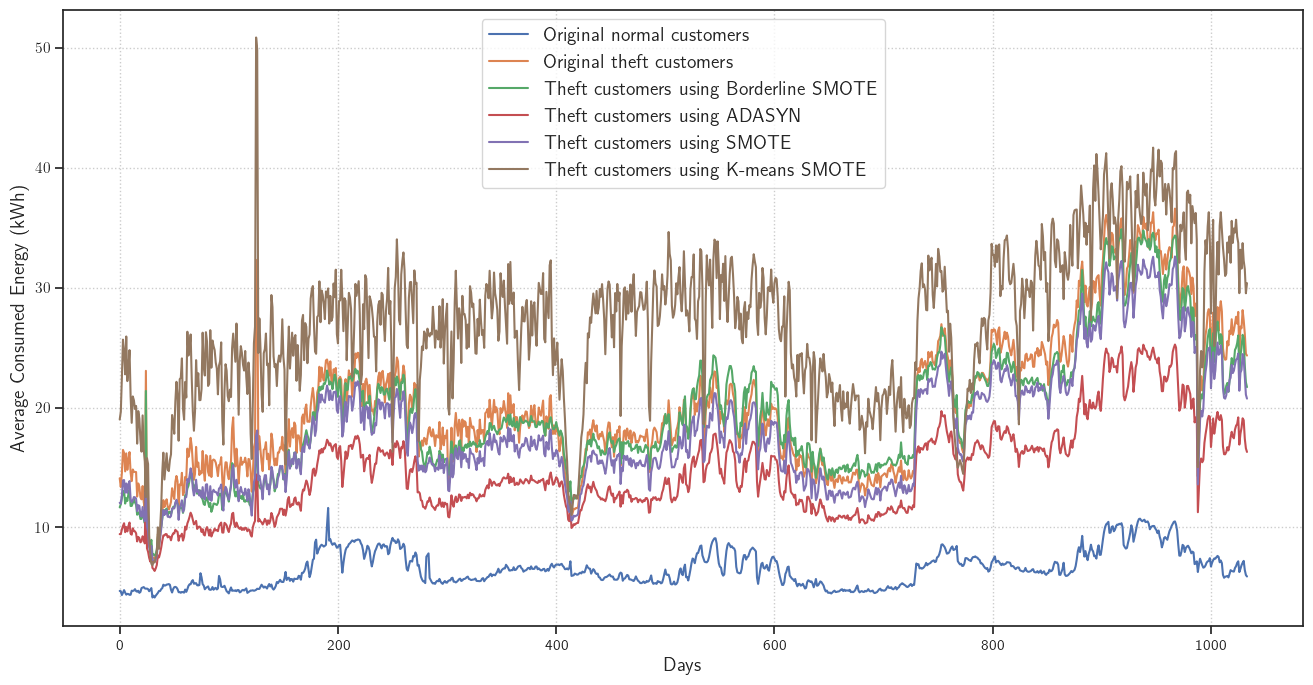

In [60]:
import matplotlib as mpl
import matplotlib.patches as mpatches

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

sns.set_theme(style="ticks")

plt.figure(figsize=(16, 8))

visualize_df = df_combined.copy(deep=True) 

attack_df = visualize_df[visualize_df['FLAG'] == 1]
normal_df = visualize_df[visualize_df['FLAG'] == 0]

# Calculate the average (mean) value per column
average_values_normal = normal_df.iloc[:, 2:].mean()
average_values_attack = attack_df.iloc[:, 2:].mean()
average_values_smote = pd.DataFrame(x_resampled_smote[y_resampled_smote == 1]).mean()
average_values_adasyn = pd.DataFrame(x_resampled_adasyn[y_resampled_adasyn == 1]).mean()
average_values_borderline = pd.DataFrame(x_resampled_borderline[y_resampled_borderline == 1]).mean()
# average_values_ksm = pd.DataFrame(x_resampled_ksm).mean()
average_values_ksm = pd.DataFrame(ksm_df[ksm_df['label'] == 1].iloc[:, :-3]).mean()
average_values_ksm /= 14

line_width = 1.5
font_size = 14

# Plot the Series
average_values_normal.plot(label='Original normal customers', linewidth=line_width)
average_values_attack.plot(label='Original theft customers', linewidth=line_width)
average_values_borderline.plot(label='Theft customers using Borderline SMOTE', linewidth=line_width)
average_values_adasyn.plot(label='Theft customers using ADASYN', linewidth=line_width)
average_values_smote.plot(label='Theft customers using SMOTE', linewidth=line_width)
average_values_ksm.plot(label='Theft customers using K-means SMOTE', linewidth=line_width)

# For reduced

# visualize_df = train_data_reduced.copy(deep=True)

# attack_df = visualize_df[visualize_df['label'] == 1]
# normal_df = visualize_df[visualize_df['label'] == 0]

# # Calculate the average (mean) value per column
# average_values_normal = normal_df.iloc[:, :-3].mean()
# average_values_attack = attack_df.iloc[:, :-3].mean()

# # Plot the Series

# average_values_normal.plot(label='Normal Reduced')
# average_values_attack.plot(label='Attack Reduced')
plt.grid(True, linestyle=':')
plt.legend(fontsize=font_size)    

# plt.title('Average Consumption of Normal and Attack Consumers', fontsize=16, pad=10)
plt.xlabel('Days', fontsize=font_size)
plt.ylabel('Average Consumed Energy (kWh)', fontsize=font_size)

# Show the plot
plt.show()

In [34]:
print(y_resampled_ksm.shape)
resample = pd.DataFrame(x_resampled_ksm)
resample.head()

(58302,)


,0,1,2,3,4,5,6,7,8,9,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91


In [35]:
resample['data'] = resample[resample.columns].values.tolist()
df_apr = resample['data']
df_apr

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [2.9, 5.64, 6.99, 3.32, 3.61, 5.35, 4.73, 3.68...
3        [0.11, 0.11, 0.25, 0.27, 0.21, 0.2, 0.14, 0.34...
4        [0.91, 1.16, 0.75, 1.3, 0.74, 0.94, 0.85, 1.21...
                               ...                        
58297    [119.71334749862577, 122.50092419590307, 122.4...
58298    [114.20769689320774, 114.3389462878107, 115.78...
58299    [98.33985038042627, 163.88627814341265, 117.72...
58300    [137.6079236584189, 136.07530053468886, 112.19...
58301    [97.71131482448031, 413.4923031068453, 521.467...
Name: data, Length: 58302, dtype: object

In [36]:
import torch.nn.functional as F

window_size = 28 # 4weeks
output_shape = (1036 // window_size, window_size)
print(output_shape)
strided_size = output_shape[0]
print(strided_size)

# padded_arr = np.pad(arr, (0, 1089 - len(arr)), 'constant')
# matrix1 = padded_arr.reshape(33, 33)

# print(np.arange(20))
# np.lib.stride_tricks.as_strided(np.arange(30), (6,5), (8*5, 8))

def stride(x):
    as_strided = np.lib.stride_tricks.as_strided
    # x = pd.Series(x) # no padding
    # print(len(x)) 1034 
    x = np.pad(pd.Series(x), (0, 2), 'constant') # padding 
    return as_strided(x, output_shape, (8*window_size, 8))

data = df_apr.apply(stride)
data

(37, 28)
37


0        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2        [[2.9, 5.64, 6.99, 3.32, 3.61, 5.35, 4.73, 3.6...
3        [[0.11, 0.11, 0.25, 0.27, 0.21, 0.2, 0.14, 0.3...
4        [[0.91, 1.16, 0.75, 1.3, 0.74, 0.94, 0.85, 1.2...
                               ...                        
58297    [[119.71334749862577, 122.50092419590307, 122....
58298    [[114.20769689320774, 114.3389462878107, 115.7...
58299    [[98.33985038042627, 163.88627814341265, 117.7...
58300    [[137.6079236584189, 136.07530053468886, 112.1...
58301    [[97.71131482448031, 413.4923031068453, 521.46...
Name: data, Length: 58302, dtype: object

In [38]:
df_dpr = data.to_frame()
df_dpr['label'] = y_resampled_ksm
df_dpr.shape

(58302, 2)

In [40]:
data_dir = '../data/ksm_transformer/'
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


data, label = df_dpr['data'], df_dpr['label']
print(len(data), len(label))
    
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

for mode in ['train', 'test']:
    if mode == 'train':
        data = X_train
        label = y_train
        save_file = f'{data_dir}/train.npz'
    else:
        data = X_test
        label = y_test
        save_file = f'{data_dir}/val.npz'
    np.savez_compressed(save_file, data=data, label=label)

58302 58302


In [302]:
dataloader = np.load(save_file, allow_pickle=True)

df = pd.DataFrame({key: dataloader[key] for key in dataloader.keys()})

df

,data,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
1,"[[0.03, 0.01, 0.01, 0.01, 0.0, 0.01, 0.0, 0.01...",0
2,"[[16.97, 15.08, 15.86, 13.36, 15.19, 13.43, 12...",0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
...,...,...
6301,"[[0.0, 4.15, 0.0, 5.73, 6.8, 8.27, 6.11, 5.69,...",0
6302,"[[5.18, 6.86, 0.0, 0.0, 0.0, 7.54, 5.07, 0.0, ...",0
6303,"[[9.79, 9.63, 7.85, 8.49, 8.75, 8.23, 8.8, 5.9...",0
6304,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
